# FT-Transformer Training for Online Shoppers Classification

This notebook implements the **FT-Transformer (Feature Tokenizer + Transformer)** architecture for tabular data classification on the Online Shoppers Purchasing Intention dataset using the `rtdl` library.

## FT-Transformer Overview

The FT-Transformer is a Transformer-based architecture specifically designed for tabular data that:
- Converts numerical and categorical features into embeddings
- Uses attention mechanisms to capture feature interactions
- Applies layer normalization and residual connections
- Provides state-of-the-art performance on many tabular datasets

## Implementation Details

- **Feature Tokenization**: Each feature is converted to a token embedding
- **Positional Encoding**: Features get positional information
- **Multi-Head Attention**: Captures complex feature interactions
- **Feed-Forward Networks**: Non-linear transformations
- **Classification Head**: Final prediction layer for binary classification

**Reference**: Gorishniy, Y., Rubachev, I., Khrulkov, V., & Babenko, A. (2021). Revisiting Deep Learning Models for Tabular Data. arXiv preprint arXiv:2106.11959.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ML libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Import rtdl library for FT-Transformer
try:
    import rtdl
    print("✅ rtdl library imported successfully")
    print(f"rtdl version: {rtdl.__version__ if hasattr(rtdl, '__version__') else 'unknown'}")
except ImportError:
    print("❌ rtdl library not available. Install with: pip install rtdl")
    print("This notebook requires the rtdl library to run.")
    raise ImportError("Please install rtdl: pip install rtdl")

# Import our custom evaluation framework
try:
    from enhanced_evaluation import ComprehensiveEvaluator
    print("✅ Enhanced evaluation imported successfully")
except ImportError:
    print("⚠️ Enhanced evaluation not available. Using basic evaluation.")
    ComprehensiveEvaluator = None

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("🤖 FT-Transformer Training for Online Shoppers Classification")
print("Dataset: Online Shoppers Purchasing Intention")

✅ rtdl library imported successfully
rtdl version: 0.0.13
✅ Enhanced evaluation imported successfully
Using device: cuda
🤖 FT-Transformer Training for Online Shoppers Classification
Dataset: Online Shoppers Purchasing Intention


## Load Preprocessed Data

In [2]:
# Load preprocessed data from Section 1
import pickle

try:
    with open('./online_shoppers_preprocessed_data.pkl', 'rb') as f:
        preprocessing_data = pickle.load(f)
    
    # Extract variables
    X_train_scaled = preprocessing_data['X_train_scaled']
    X_val_scaled = preprocessing_data['X_val_scaled']
    X_test_scaled = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_val = preprocessing_data['y_val']
    y_test = preprocessing_data['y_test']
    feature_names = preprocessing_data['feature_names']
    month_mapping = preprocessing_data['month_mapping']
    visitor_mapping = preprocessing_data['visitor_mapping']
    data_summary = preprocessing_data['data_summary']
    
    print("✅ Preprocessed data loaded successfully!")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Validation set: {X_val_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: 2 (Binary Classification)")
    print(f"Class names: ['No Purchase', 'Purchase']")

    # After loading your preprocessed data, before moving to GPU
    print("\nChecking for invalid values...")
    print(f"NaN in X_train: {np.isnan(X_train_scaled).any()}")
    print(f"Inf in X_train: {np.isinf(X_train_scaled).any()}")
    print(f"NaN in y_train: {np.isnan(y_train).any()}")

    # Check data ranges
    print(f"X_train min: {X_train_scaled.min()}, max: {X_train_scaled.max()}")
    print(f"y_train min: {y_train.min()}, max: {y_train.max()}")
    
except FileNotFoundError:
    print("❌ Preprocessed data not found!")
    print("Please run Section 1 (Data Preprocessing) notebook first.")
    raise

# After loading preprocessed data, before tensor creation
import gc

# Clean up any existing GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Force garbage collection
gc.collect()

# Check GPU memory
if torch.cuda.is_available():
    print(f"\nGPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"\n📊 Data converted to PyTorch tensors on {device}")
print(f"Input features: {X_train_tensor.shape[1]}")
print(f"Number of classes: 2 (Binary Classification)")

# Get class names for visualization
class_names = ['No Purchase', 'Purchase']
n_features = X_train_tensor.shape[1]
n_classes = 2

✅ Preprocessed data loaded successfully!
Training set: (7891, 17)
Validation set: (1973, 17)
Test set: (2466, 17)
Features: 17
Classes: 2 (Binary Classification)
Class names: ['No Purchase', 'Purchase']

Checking for invalid values...
NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
X_train min: -2.488996784845566, max: 32.206070260503154
y_train min: 0, max: 1

GPU memory allocated: 0.00 MB
GPU memory cached: 0.00 MB

📊 Data converted to PyTorch tensors on cuda
Input features: 17
Number of classes: 2 (Binary Classification)


## Data Preparation for FT-Transformer

In [3]:
# Prepare data for FT-Transformer
# FT-Transformer expects specific data format with feature information

# Since all features are numerical (after preprocessing), we treat them as continuous
# Create feature info for rtdl
feature_info = {
    'n_num_features': n_features,  # All features are numerical
    'n_cat_features': 0,           # No categorical features after preprocessing
    'cat_cardinalities': []        # Empty since no categorical features
}

print(f"📋 Feature Information:")
print(f"   Numerical features: {feature_info['n_num_features']}")
print(f"   Categorical features: {feature_info['n_cat_features']}")
print(f"   Feature names: {feature_names[:5]}... (showing first 5)")

# Create data loaders
batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n🔄 Data loaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📋 Feature Information:
   Numerical features: 17
   Categorical features: 0
   Feature names: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated']... (showing first 5)

🔄 Data loaders created:
   Batch size: 256
   Train batches: 31
   Validation batches: 8
   Test batches: 10


## FT-Transformer Model Configuration

In [4]:
# FT-Transformer hyperparameters

# Training hyperparameters
training_config = {
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'n_epochs': 100,
    'patience': 15,  # Early stopping patience
    'min_delta': 1e-4  # Minimum improvement for early stopping
}

print("\n📚 Training Configuration:")
for key, value in training_config.items():
    print(f"   {key}: {value}")


📚 Training Configuration:
   learning_rate: 0.0001
   weight_decay: 1e-05
   n_epochs: 100
   patience: 15
   min_delta: 0.0001


## FT-Transformer Model Creation

In [5]:
# Create FT-Transformer using rtdl library
print("🤖 Creating FT-Transformer using rtdl library...")

model = rtdl.FTTransformer.make_default(
    n_num_features=feature_info['n_num_features'],
    cat_cardinalities=feature_info['cat_cardinalities'],
    d_out=n_classes
)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")
print(f"   Task: Binary Classification (Purchase Prediction)")

🤖 Creating FT-Transformer using rtdl library...

📊 Model Statistics:
   Total parameters: 898,562
   Trainable parameters: 898,562
   Model size: ~3.43 MB
   Task: Binary Classification (Purchase Prediction)


## Training Setup

In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=training_config['learning_rate'],
    weight_decay=training_config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print("🔧 Training setup completed:")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: AdamW (lr={training_config['learning_rate']}, wd={training_config['weight_decay']})")
print(f"   Scheduler: ReduceLROnPlateau")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'learning_rates': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

🔧 Training setup completed:
   Loss function: CrossEntropyLoss
   Optimizer: AdamW (lr=0.0001, wd=1e-05)
   Scheduler: ReduceLROnPlateau


## Training Functions

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # For rtdl FTTransformer, we need to pass data in the expected format
        # Since we only have numerical features, we pass None for categorical
        output = model(data, None)  # (numerical_features, categorical_features)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            # For rtdl FTTransformer, we need to pass data in the expected format
            output = model(data, None)  # (numerical_features, categorical_features)
            
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("✅ Training functions defined")

✅ Training functions defined


## Training Loop

In [8]:
print("🚀 Starting FT-Transformer training...")
print(f"Training for {training_config['n_epochs']} epochs with early stopping (patience={training_config['patience']})")
print("-" * 80)

start_time = time.time()

for epoch in range(training_config['n_epochs']):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Early stopping check
    if val_loss < best_val_loss - training_config['min_delta']:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:3d}/{training_config['n_epochs']} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.2e} | Patience: {patience_counter}/{training_config['patience']}")
    
    # Early stopping
    if patience_counter >= training_config['patience']:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
        break

training_time = time.time() - start_time

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Loaded best model from epoch {best_epoch+1}")

print(f"\n🏁 Training completed in {training_time:.2f} seconds")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final validation accuracy: {history['val_acc'][best_epoch]:.2f}%")

🚀 Starting FT-Transformer training...
Training for 100 epochs with early stopping (patience=15)
--------------------------------------------------------------------------------
Epoch   1/100 | Train Loss: 0.3718 | Train Acc: 85.39% | Val Loss: 0.2712 | Val Acc: 88.60% | LR: 1.00e-04 | Patience: 0/15
Epoch   2/100 | Train Loss: 0.2663 | Train Acc: 89.49% | Val Loss: 0.2390 | Val Acc: 89.51% | LR: 1.00e-04 | Patience: 0/15
Epoch   3/100 | Train Loss: 0.2593 | Train Acc: 89.51% | Val Loss: 0.2462 | Val Acc: 89.71% | LR: 1.00e-04 | Patience: 1/15
Epoch   4/100 | Train Loss: 0.2463 | Train Acc: 89.81% | Val Loss: 0.2309 | Val Acc: 89.61% | LR: 1.00e-04 | Patience: 0/15
Epoch   5/100 | Train Loss: 0.2456 | Train Acc: 90.05% | Val Loss: 0.2325 | Val Acc: 89.71% | LR: 1.00e-04 | Patience: 1/15
Epoch  10/100 | Train Loss: 0.2321 | Train Acc: 90.42% | Val Loss: 0.2214 | Val Acc: 89.96% | LR: 1.00e-04 | Patience: 0/15
Epoch  20/100 | Train Loss: 0.2175 | Train Acc: 90.82% | Val Loss: 0.2231 | Val

## Training Visualization

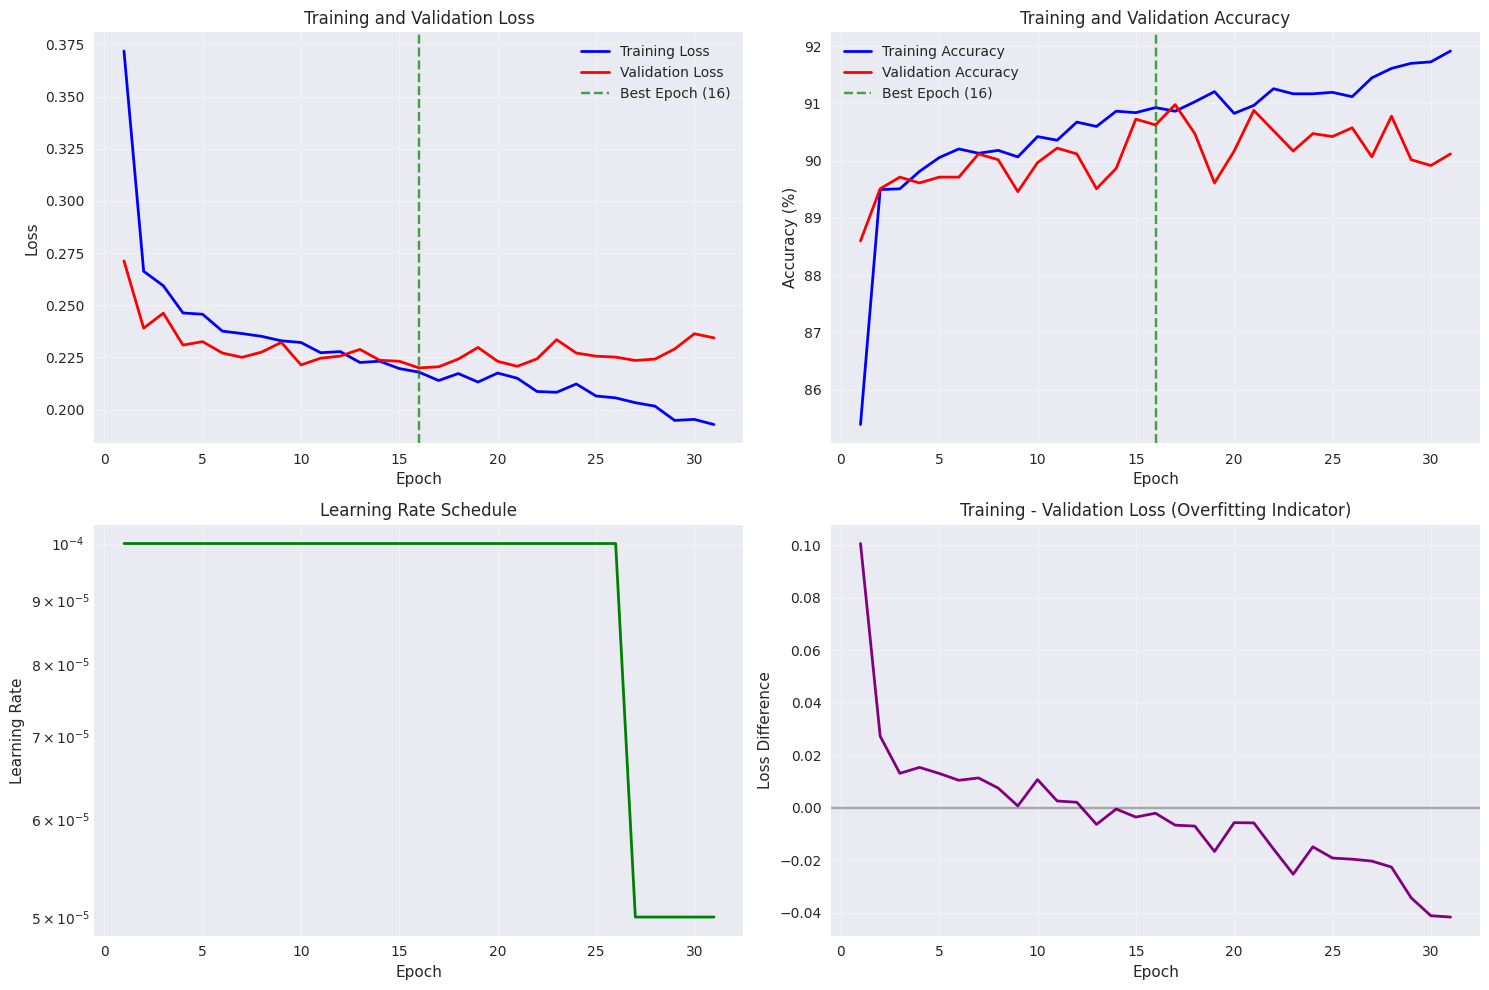


📈 Training Summary:
   Total epochs: 31
   Best epoch: 16
   Best validation loss: 0.2199
   Training time: 17.96 seconds
   Final learning rate: 5.00e-05


In [9]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = np.array(history['train_loss']) - np.array(history['val_loss'])
axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Training - Validation Loss (Overfitting Indicator)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss Difference')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Section2_Model_Training/FT_Transformer_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Training Summary:")
print(f"   Total epochs: {len(history['train_loss'])}")
print(f"   Best epoch: {best_epoch+1}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Final learning rate: {history['learning_rates'][-1]:.2e}")

## Initialize Enhanced Evaluator

In [10]:
# Initialize the comprehensive evaluator
evaluator = ComprehensiveEvaluator()

# Create PyTorch model wrapper for the FT-Transformer
ft_wrapper = evaluator.create_pytorch_wrapper(
    model=model,
    device=device,
    batch_size=256
)

print("✅ Enhanced evaluator initialized")
print("✅ FT-Transformer wrapper created")
print(f"   Device: {device}")
print(f"   Batch size: 256")

✅ Enhanced evaluator initialized
✅ FT-Transformer wrapper created
   Device: cuda
   Batch size: 256


## Comprehensive Model Evaluation

This section performs a complete evaluation of the FT-Transformer model using the enhanced evaluation framework.

🚀 Starting comprehensive FT-Transformer evaluation...
This may take a few minutes depending on your hardware.

Evaluating FT-Transformer
ℹ️ Skipping cross-validation for PyTorch model (already trained)

📊 Performance Metrics:
   Accuracy: 0.8958
   Balanced Accuracy: 0.7812
   Precision: 0.6812
   Recall: 0.6152
   F1-Score: 0.6465
   Matthews Correlation: 0.5866
   AUC-ROC: 0.9220
   Average Precision: 0.7335
   Log Loss: 0.2432
   Brier Score: 0.0740

⏱️  Timing:
   Training Time: 0.0000s
   Inference Time: 0.0454s
   Predictions/sec: 54300


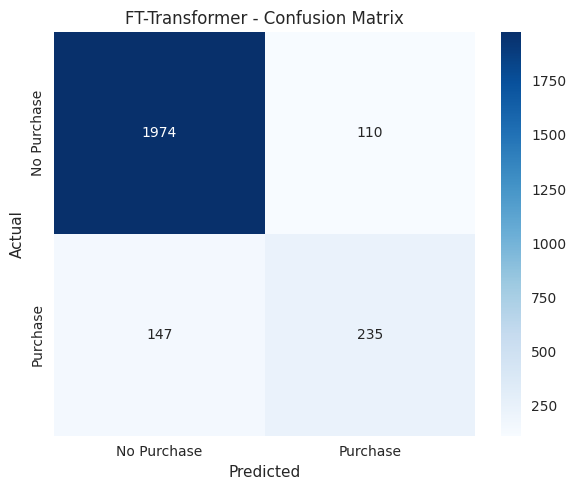

<Figure size 800x550 with 0 Axes>

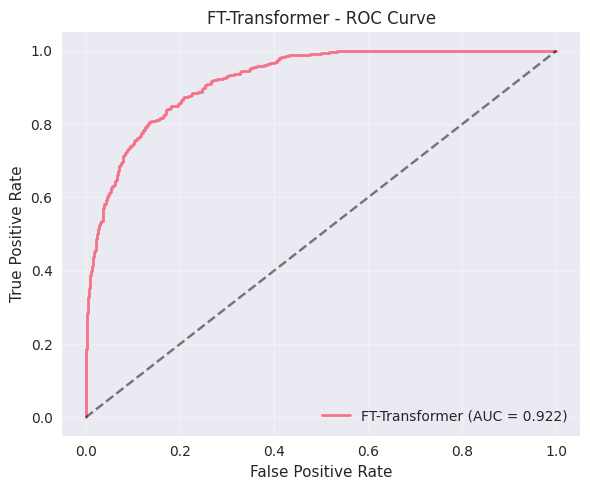

<Figure size 800x550 with 0 Axes>

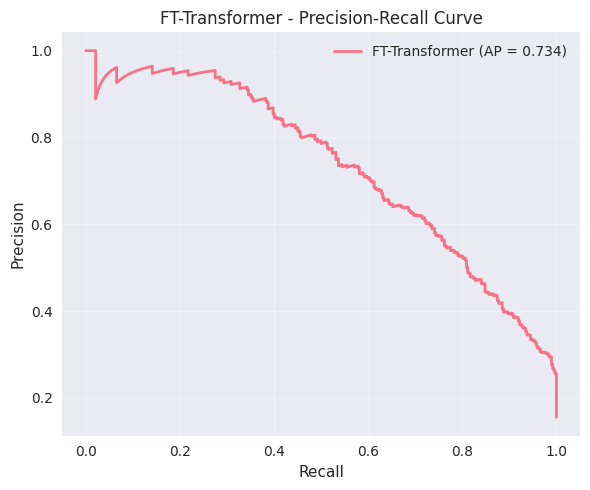

<Figure size 800x550 with 0 Axes>

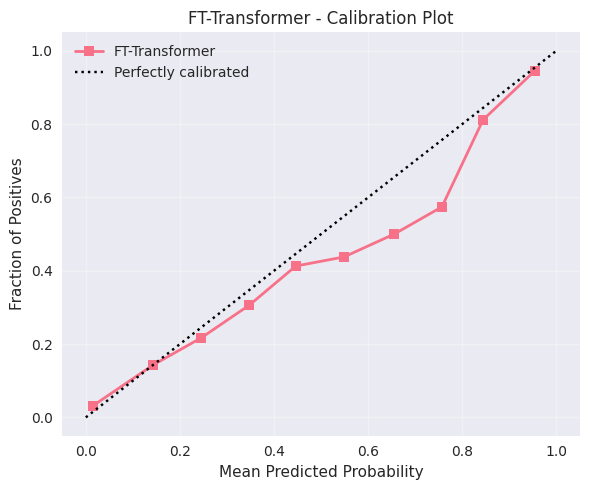


✅ FT-Transformer evaluation completed!


<Figure size 800x550 with 0 Axes>

In [11]:
# Perform comprehensive evaluation
print("🚀 Starting comprehensive FT-Transformer evaluation...")
print("This may take a few minutes depending on your hardware.")

# Evaluate the FT-Transformer model
ft_results = evaluator.evaluate_model(
    model=ft_wrapper,
    model_name="FT-Transformer",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    X_val=X_val_scaled,
    y_val=y_val,
    predict_proba_available=True
)

print("\n✅ FT-Transformer evaluation completed!")

## Detailed Results Analysis

In [12]:
# Display detailed results
print("📊 DETAILED FT-TRANSFORMER RESULTS")
print("=" * 60)

# Create results DataFrame for better visualization
results_df = pd.DataFrame([ft_results]).T
results_df.columns = ['FT-Transformer']

# Performance metrics
performance_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'mcc']
if 'auc_roc' in results_df.index:
    performance_metrics.append('auc_roc')
if 'log_loss' in results_df.index:
    performance_metrics.append('log_loss')

print("\n🎯 Performance Metrics:")
performance_df = results_df.loc[performance_metrics]
for metric in performance_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        print(f"   {metric.replace('_', ' ').title()}: {value:.4f}")

# Timing metrics
timing_metrics = ['train_time', 'inference_time', 'predictions_per_second']
print("\n⏱️ Timing Metrics:")
for metric in timing_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        if metric == 'predictions_per_second':
            print(f"   {metric.replace('_', ' ').title()}: {value:.0f}")
        else:
            print(f"   {metric.replace('_', ' ').title()}: {value:.4f}s")

# Cross-validation metrics (if available)
if 'cv_f1_mean' in results_df.index:
    print("\n🔄 Cross-Validation:")
    cv_mean = results_df.loc['cv_f1_mean', 'FT-Transformer']
    cv_std = results_df.loc['cv_f1_std', 'FT-Transformer']
    print(f"   F1 Score: {cv_mean:.4f} ± {cv_std:.4f}")

📊 DETAILED FT-TRANSFORMER RESULTS

🎯 Performance Metrics:
   Accuracy: 0.8958
   Balanced Accuracy: 0.7812
   Precision: 0.6812
   Recall: 0.6152
   F1: 0.6465
   Mcc: 0.5866
   Auc Roc: 0.9220
   Log Loss: 0.2432

⏱️ Timing Metrics:
   Train Time: 0.0000s
   Inference Time: 0.0454s
   Predictions Per Second: 54300


## Model Performance Summary

In [ ]:
# Create a comprehensive summary
print("📈 FT-TRANSFORMER PERFORMANCE SUMMARY")
print("=" * 50)

# Get predictions for additional analysis
y_pred = ft_wrapper.predict(X_test_scaled)
y_proba = ft_wrapper.predict_proba(X_test_scaled)

# Per-class analysis for binary classification
from sklearn.metrics import precision_recall_fscore_support, classification_report

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

print("\n📋 Per-Class Performance:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precision_per_class[i]:<10.4f} "
          f"{recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f} "
          f"{support_per_class[i]:<10.0f}")

# Binary classification specific metrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Binary Classification Metrics:")
print(f"   True Negatives (Correct No Purchase): {tn}")
print(f"   False Positives (Incorrect Purchase): {fp}")
print(f"   False Negatives (Missed Purchase): {fn}")
print(f"   True Positives (Correct Purchase): {tp}")
print(f"   Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")
print(f"   Specificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"   False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   False Negative Rate: {fn/(fn+tp):.4f}")

# Overall assessment
overall_accuracy = ft_results['accuracy']
overall_f1 = ft_results['f1']
roc_auc = ft_results.get('auc_roc', 'N/A')

print(f"\n🎯 Overall Assessment:")
if overall_accuracy > 0.9:
    print(f"   Excellent performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.8:
    print(f"   Good performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.7:
    print(f"   Moderate performance (Accuracy: {overall_accuracy:.4f})")
else:
    print(f"   Needs improvement (Accuracy: {overall_accuracy:.4f})")

print(f"   Weighted F1-Score: {overall_f1:.4f}")
if roc_auc != 'N/A':
    print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   Model complexity: {total_params:,} parameters")
print(f"   Inference speed: {ft_results['predictions_per_second']:.0f} predictions/second")

# Business insights for online shoppers
print(f"\n💼 Business Insights:")
if precision_per_class[1] > 0.8:  # Purchase class precision
    print(f"   ✅ High purchase precision ({precision_per_class[1]:.4f}) - Low false positive rate")
    print(f"   📊 Good for targeted marketing campaigns")
if recall_per_class[1] > 0.8:  # Purchase class recall
    print(f"   ✅ High purchase recall ({recall_per_class[1]:.4f}) - Captures most potential buyers")
    print(f"   📊 Good for maximizing revenue opportunities")
if tp/(tp+fn) > 0.7:  # Sensitivity
    print(f"   ✅ Good sensitivity - Identifies most customers likely to purchase")
if tn/(tn+fp) > 0.8:  # Specificity
    print(f"   ✅ Good specificity - Avoids targeting unlikely customers")

## ROC and Precision-Recall Analysis

In [ ]:
# ROC and Precision-Recall curves for binary classification
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - FT-Transformer')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
avg_precision = average_precision_score(y_test, y_proba[:, 1])
axes[1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - FT-Transformer')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('online_shoppers/Section2_Model_Training/FT_Transformer_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Curve Analysis:")
print(f"   ROC-AUC: {roc_auc:.4f} - {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Moderate'} discrimination")
print(f"   Average Precision: {avg_precision:.4f} - {'Excellent' if avg_precision > 0.8 else 'Good' if avg_precision > 0.6 else 'Moderate'} precision-recall trade-off")

## Save Evaluation Results

In [ ]:
# Save evaluation results
print("💾 Saving evaluation results...")

# Save detailed results
results_df.to_csv('online_shoppers/Section2_Model_Training/ft_transformer_evaluation_results.csv')
print("✅ Detailed results saved to 'online_shoppers/Section2_Model_Training/ft_transformer_evaluation_results.csv'")

# Save per-class results
per_class_results = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})
per_class_results.to_csv('online_shoppers/Section2_Model_Training/ft_transformer_per_class_results.csv', index=False)
print("✅ Per-class results saved to 'online_shoppers/Section2_Model_Training/ft_transformer_per_class_results.csv'")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'true_labels': y_test,
    'predicted_labels': y_pred,
    'max_probability': np.max(y_proba, axis=1),
    'prob_no_purchase': y_proba[:, 0],
    'prob_purchase': y_proba[:, 1]
})

predictions_df.to_csv('online_shoppers/Section2_Model_Training/ft_transformer_predictions.csv', index=False)
print("✅ Predictions saved to 'online_shoppers/Section2_Model_Training/ft_transformer_predictions.csv'")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv('online_shoppers/Section2_Model_Training/ft_transformer_training_history.csv', index=False)
print("✅ Training history saved to 'online_shoppers/Section2_Model_Training/ft_transformer_training_history.csv'")

# Save model state (optional - can be large)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_config': training_config,
    'feature_info': feature_info,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'total_params': total_params
}, 'online_shoppers/Section2_Model_Training/ft_transformer_model.pth')
print("✅ Model checkpoint saved to 'online_shoppers/Section2_Model_Training/ft_transformer_model.pth'")

print("\n🎉 FT-Transformer evaluation completed successfully!")
print("\n📁 Generated files:")
print("   - ft_transformer_evaluation_results.csv")
print("   - ft_transformer_per_class_results.csv")
print("   - ft_transformer_predictions.csv")
print("   - ft_transformer_training_history.csv")
print("   - ft_transformer_model.pth")
print("   - FT_Transformer_training_history.png")
print("   - FT_Transformer_roc_pr_curves.png")

## Final Summary

In [ ]:
# Final comprehensive summary
print("\n" + "="*80)
print("FT-TRANSFORMER TRAINING COMPLETION SUMMARY")
print("="*80)
print(f"✅ Model Successfully Trained: FT-Transformer")
print(f"\n📊 Training Statistics:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Training Time: {training_time:.2f} seconds")
print(f"   Best Epoch: {best_epoch+1}")
print(f"   Final Validation Accuracy: {history['val_acc'][best_epoch]:.2f}%")
print(f"\n🎯 Performance Metrics:")
print(f"   Test Accuracy: {overall_accuracy:.4f}")
print(f"   F1-Score: {overall_f1:.4f}")
print(f"   ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")
print(f"   Precision (Purchase): {precision_per_class[1]:.4f}")
print(f"   Recall (Purchase): {recall_per_class[1]:.4f}")
print(f"\n💼 Business Impact:")
print(f"   Purchase Prediction Accuracy: {f1_per_class[1]:.4f} F1-Score")
print(f"   False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"   False Negative Rate: {fn/(fn+tp)*100:.2f}%")
print(f"\n🎯 Dataset: Online Shoppers Purchasing Intention")
print(f"📊 Task: Binary Classification (Purchase Prediction)")
print(f"🔢 Features: {len(feature_names)}")
print(f"📈 Training Samples: {len(X_train_scaled):,}")
print(f"🧪 Test Samples: {len(X_test_scaled):,}")
print(f"\n🚀 Model ready for deployment and integration with other models!")